In [20]:
import pandas as pd
import math
from bioinfokit import analys, visuz
from matplotlib import pyplot as plt

L_0 = 132000000 # Genome size
PSEUDOCOUNT = 5 # delta term
REP_NUM = '1'
OUT_NAME = 'Openness output/rep'+REP_NUM+'_peaks_volcano'

In [21]:
peak_data48 = [] # List to store (peak height, peak length, p-value, chrom, start) tuples
Y48 = 0 # Initialize genome peak aggregate for 48hr sample
narrowPeak_file = open('narrowPeak/48hr_rep'+REP_NUM+'.narrowPeak', 'r')
for peak in narrowPeak_file:
    data = peak.split()
    height = float(data[6])
    length = float(data[2]) - float(data[1])
    Y48 += height # Construct Y term for 48hr sample

    pvalue = float(data[7])
    chrom = data[0]
    start = float(data[2])
    peak_data48.append((height, length, pvalue, chrom, start))
narrowPeak_file.close()
peak_data48[:5]

[(304.992889, 308.0, 3.695203, 'chr2L', 67012.0),
 (273.987305, 582.0, 3.1352, 'chr2L', 73640.0),
 (262.300873, 372.0, 3.695203, 'chr2L', 155641.0),
 (311.204437, 192.0, 4.700867, 'chr2L', 156226.0),
 (420.742798, 638.0, 3.931839, 'chr2L', 161166.0)]

In [22]:
peak_data72 = [] # List to store (peak height, peak length, p-value, chrom, start) tuples
narrowPeak_file = open('narrowPeak/72hr_rep'+REP_NUM+'.narrowPeak', 'r')
Y72 = 0 # Initialize genome peak aggregate for 72hr sample
for peak in narrowPeak_file:
    data = peak.split()
    height = float(data[6])
    length = float(data[2]) - float(data[1])
    Y72 += height # Construct Y term for 72hr sample

    pvalue = float(data[7])
    chrom = data[0]
    start = float(data[2])
    peak_data72.append((height, length, pvalue, chrom, start))
narrowPeak_file.close()
peak_data72[:5]

[(442.782074, 373.0, 4.08179, 'chr2L', 67062.0),
 (1127.309082, 1409.0, 4.41474, 'chr2L', 73544.0),
 (230.110138, 407.0, 3.552834, 'chr2L', 74125.0),
 (232.691132, 482.0, 3.319226, 'chr2L', 108303.0),
 (219.805557, 272.0, 3.625748, 'chr2L', 109464.0)]

In [23]:
# Align peaks between 48hr and 72hr data if the peak start is within 50bp of each other
# (choose the closest if there's multiple)
matched_peaks = [] # [((48hr peak tuple) or None, (72hr peak tuple) or None)]
match_count = 0
only48 = 0
only72 = 0
# First go through 48hr peaks and match to 72hr, popping from the respective list when a peak is added to
# the list of matched peaks
print(len(peak_data48), len(peak_data72), len(matched_peaks))
while len(peak_data48) > 0:
    peak = peak_data48.pop()
    matches = [p for p in peak_data72 if p[3]==peak[3] and p[4] >= peak[4]-50 and p[4] <= peak[4]+50]
    if len(matches) == 0:
#         matched_peaks.append((peak, None))
        only48 += 1
    else:
        chosen_peak = sorted(matches, key=lambda p: abs(peak[4]-p[4]))[0]
        matched_peaks.append((peak, chosen_peak))
        match_count += 1
        peak_data72.remove(chosen_peak)
print(len(peak_data48), len(peak_data72), len(matched_peaks))

# Go through remaining peaks in 72hr list
while len(peak_data72) > 0:
    peak = peak_data72.pop()
#     matched_peaks.append((None, peak))
    only72 += 1
print(len(peak_data48), len(peak_data72), len(matched_peaks))

1359 2016 0
0 1347 669
0 0 669


In [24]:
print(match_count, ' matched peaks')
print(only48, ' peaks only in 48hr')
print(only72, ' peaks only in 72hr')

669  matched peaks
690  peaks only in 48hr
1347  peaks only in 72hr


In [25]:
# Get data ready for volcano plot
volcano_df = pd.DataFrame(columns=['GeneNames', 'value1', 'value2', 'log2fc', 'p-value'])
for peak48, peak72 in matched_peaks:
    # Unpack values
    if peak48:
        height48, length48, pvalue48, chrom48, _ = peak48
    if peak72:
        height72, length72, pvalue72, _, _ = peak72
    
    # Openness score for 48hr peak
    o_score48 = 0.001
    if peak48:
        X48 = height * (1-(10**(-1*pvalue48))) # Incorproate peak p-value
        L48 = length
        o_score48 = (X48 / L48) / ((Y48+PSEUDOCOUNT) / L_0)
    # Openness score for 72hr peak
    o_score72 = 0.001
    if peak72:
        X72 = height * (1-(10**(-1*pvalue72))) # Incorproate peak p-value
        L72 = length
        o_score72 = (X72 / L72) / ((Y72+PSEUDOCOUNT) / L_0)
        
    # Append to plot data
    fold_change = o_score72 / o_score48
    row = {'GeneNames':chrom48, 'value1':o_score72, 'value2':o_score48, 'log2fc':math.log2(fold_change), 'p-value':min(pvalue48, pvalue72)}
    volcano_df = volcano_df.append(row, ignore_index=True)

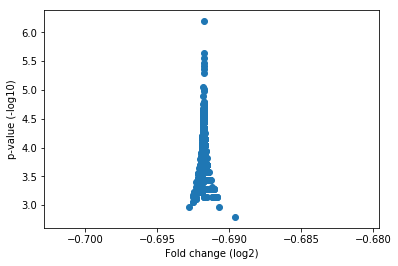

In [26]:
# Create matplotlib plot
x = volcano_df['log2fc']
y = volcano_df['p-value']
plt.ylabel('p-value (-log10)')
plt.xlabel('Fold change (log2)')
plt.scatter(x, y)
plt.savefig('Openness output/matched_peaks_'+str(REP_NUM)+'_volcano.png')

In [112]:
# Create volcano plot
visuz.gene_exp.volcano(df=volcano_df, lfc='log2fc', pv='p-value', figname=OUT_NAME, lfc_thr=2)

In [130]:
min(volcano_df['log2fc']), max(volcano_df['log2fc'])

(-0.6258628289809944, -0.6225053457644498)